In [1]:
import pandas as pd
import random
import numpy as np
import time
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import struct
from bisect import bisect_left, bisect_right


In [2]:
import sys
sys.path.append('/home/ipsarros/FrechetMotifs-master/bin/')
import subann

In [3]:
import pyarrow as pa
from pyarrow.flight import Location
#leviathan.imsi.athenarc.gr 9999
modelarUrl = "leviathan.imsi.athenarc.gr"
modelarPort = 9999

# create a Location for gRPC insecure connection
#location = Location.for_grpc_insecure(modelarUrl, modelarPort)
location = Location.for_grpc_tcp(modelarUrl, modelarPort)

# create a FlightClient with the location and RootAllocator
flightClient = pa.flight.FlightClient(location=location)


Probe modelar:

In [4]:
inds = [118] #power/poa, error = 40%
tables = []
for i in inds:
    sql = "SELECT * FROM segment WHERE tid =" + str(i) 
    start_t = time.time()
    ticket = pa.flight.Ticket(sql.encode())
    stream = flightClient.do_get(ticket)
    tables.append(stream.read_pandas())
    print(time.time()-start_t)

0.27161383628845215


In [6]:
tables[0].head()

,TID,START_TIME,END_TIME,MTID,MODEL,OFFSETS
0,118,2012-12-20 10:40:00,2012-12-20 14:50:00,3,b'\xbd\xc2\xc5\x8d;\x85<\xd0@G+\x13\xa5\xf15 ',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
1,118,2012-12-20 14:55:00,2012-12-21 08:55:00,3,b'\x00\x00\x00\x00\x00\x00\x00\x00',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
2,118,2012-12-21 09:00:00,2012-12-21 15:55:00,3,b'\xbd\xc2j:\xed\xf7e\x08@F\xba\xa7wV\rH',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
3,118,2012-12-21 16:00:00,2012-12-22 08:10:00,3,b'\x00\x00\x00\x00\x00\x00\x00\x00',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
4,118,2012-12-22 08:15:00,2012-12-22 15:45:00,3,b'\xbd\xf3\x85\xe8[E\xc6\xc7@x\x150M)\xe8~',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...


Extract models:

In [7]:

series = []
for table in tables:
    values = []
    index = []
    for i in range(len(table)):        
        model = table.loc[i].MODEL
        if table.loc[i].MTID == 2:
            index.append(pd.Timestamp(table.loc[i].START_TIME))
            index.append(pd.Timestamp(table.loc[i].END_TIME))
            a = struct.unpack('>f', model)[0]
            values.append(a)
            values.append(a)
        elif table.loc[i].MTID == 3:
            index.append(pd.Timestamp(table.loc[i].START_TIME))
            index.append(pd.Timestamp(table.loc[i].END_TIME))
            if len(model)== 8:
                a,b = struct.unpack('>ff', model)
            elif len(model) == 16:    
                a,b = struct.unpack('>dd', model)
            x = pd.Timestamp(table.loc[i].START_TIME).timestamp()*1000
            values.append(a*x+b)
            y = pd.Timestamp(table.loc[i].END_TIME).timestamp()*1000
            values.append(a*y+b)
        elif table.loc[i].MTID == 1:    
            #5 min granularity index between pd.Timestamp(table.loc[i].START_TIME)
            datetime_index = pd.date_range(start=pd.Timestamp(table.loc[i].START_TIME), end=pd.Timestamp(table.loc[i].END_TIME), freq='5T')
            if len(datetime_index) != int(len(model)/4): 
                print(f' {len(datetime_index)} vs {int(len(model)/4)}')
                print(datetime_index)
                print(table.loc[i].START_TIME)
                print(table.loc[i].END_TIME)

            index.extend(datetime_index)
            format_string = '>{}f'.format(int(len(model)/4))
            unpacked_data = struct.unpack(format_string, model)#[0]
            for a in unpacked_data:
                values.append(a)
        else:
            print('Something is wrong')
    series.append(pd.Series(values, index=index))    

Read original input time series (the one ingested to modelar)

In [8]:
original_signal = pd.read_csv('/home/ipsarros/modelar_data/5min_eugene_power_poa.csv',index_col='timestamp')['div']

original_signal.index = pd.to_datetime(original_signal.index)
original_signal.head()

timestamp
2012-12-20 10:40:00    0.035241
2012-12-20 10:45:00    0.037158
2012-12-20 10:50:00    0.037535
2012-12-20 10:55:00    0.036558
2012-12-20 11:00:00    0.037043
Name: div, dtype: float64

Read "groundtruth" signal: in this case soiling derate.

In [9]:
groundtruth = pd.read_csv('/home/ipsarros/eugene.csv',index_col='timestamp')
groundtruth.index = pd.to_datetime(groundtruth.soiling_derate.index)
groundtruth

,Unnamed: 0,poa,mod_temp,power,humidity,precipitation,soiling_derate
timestamp,,,,,,,
2012-12-20 10:40:02,0,22.8,4.5,0.8035,86.1,18.8,1.0
2012-12-20 10:45:02,1,31.0,4.6,1.1519,85.4,18.8,1.0
2012-12-20 10:50:02,2,34.0,4.6,1.2762,86.0,18.8,1.0
2012-12-20 10:55:02,3,29.2,4.6,1.0675,85.9,18.8,1.0
2012-12-20 11:00:02,4,32.9,4.6,1.2187,85.1,18.9,1.0
...,...,...,...,...,...,...,...
2014-01-20 16:20:02,43122,30.5,4.9,0.9706,83.7,0.0,1.0
2014-01-20 16:25:02,43123,36.4,4.6,1.1829,83.1,0.0,1.0
2014-01-20 16:30:02,43124,36.1,4.5,1.1975,83.6,0.0,1.0


Select random queries. Each query corresponds to an entire day.

0.09906983375549316


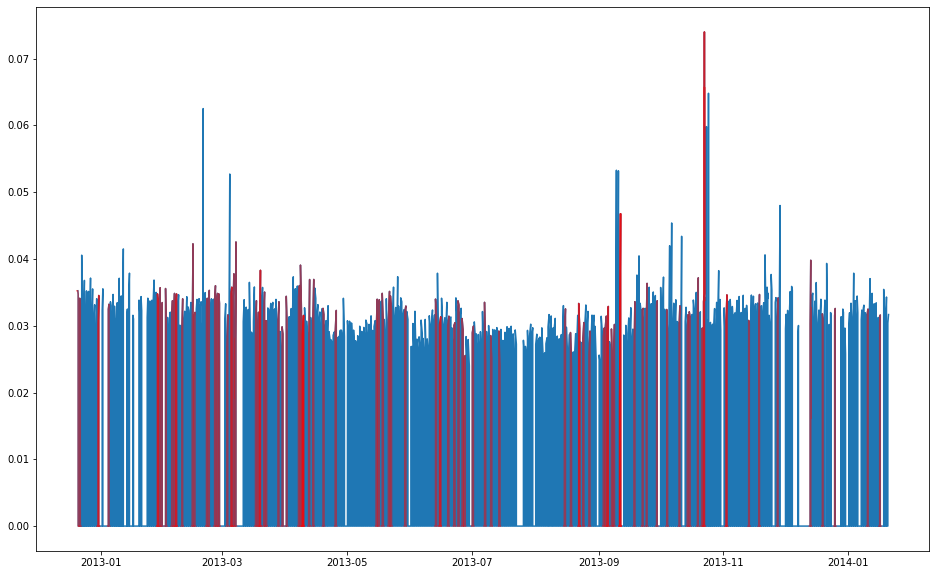

In [26]:
w = 1 #10 days
query_set = []
start_t = time.time()
signal = series[0]
start = signal.index[0]
end = signal.index[-1]
fig = plt.figure(figsize=(16,10))
# Add a plot to the figure
ax = fig.add_subplot(111)
ax.plot(signal)
for ti in random.choices(groundtruth[(groundtruth.soiling_derate == 1).values].index, k=100):
    ti = ti.replace(hour=0, minute=0, second=0)
    a = bisect_left(signal.index, ti)
    b = bisect_left(signal.index, ti+pd.Timedelta(days = w))
    if a > 0:
        edge_a = signal.iloc[a-1:a+1]
        slope_a = (edge_a.values[1]-edge_a.values[0])/(edge_a.index[1].timestamp()-edge_a.index[0].timestamp())
        intercept_a = edge_a.values[0] - slope_a*edge_a.index[0].timestamp()
        y_a = slope_a*(ti).timestamp()+intercept_a 
    else:
        y_a = signal.values[a]
    if b < len(signal)-1:    
        edge_b = signal.iloc[b-1:b+1]
        slope_b = (edge_b.values[1]-edge_b.values[0])/(edge_b.index[1].timestamp()-edge_b.index[0].timestamp())
        intercept_b = edge_b.values[0] - slope_b*edge_b.index[0].timestamp()
        y_b = slope_b*(ti+pd.Timedelta(days = w)).timestamp()+intercept_b
    else:
        y_b = signal.values[-1]
    query = np.concatenate(([y_a], signal.iloc[a:b], [y_b]))
    index = np.concatenate((pd.DatetimeIndex([ti]), signal.index[a:b].to_numpy(), pd.DatetimeIndex([ti+pd.Timedelta(days = w)])))
    ax.plot(pd.Series(query, index = index),alpha =0.5,color ='red')
    query_set.append(query)
    
print(time.time()-start_t)    


First attempt for preprocessing to verify that the parameters induce a good partitioning of the data.

In [11]:
answers = {}
times = {}
for i, signal in enumerate(series):
    start_t = time.time()
    ts = subann.TimeSeries([[x] for x in signal.values], [int(t.timestamp()-signal.index[0].timestamp()) for t in signal.index])
    DS = subann.SubAnnDS(ts, 0.01, 0.005, 600, False)
    print(f'Preprocessing time: {time.time()-start_t}')
    print(DS.stats())

Preprocessing time: 0.012747526168823242
None
Number of keys stored: 52
Average number of subsequences per key: 28.1346
Maximum bucket size: 358


Preprocessing and queries:

In [12]:
answers = {}
times = {}
R = 0.000001
W = 0.001
R = W
m = 600
for i, signal in enumerate(series):
    start_t = time.time()
    ts = subann.TimeSeries([[x] for x in signal.values], [int(t.timestamp()-signal.index[0].timestamp()) for t in signal.index])
    #DS = subann.SubAnnDS(ts, 0.005, R, m, True) #does not apply WF filtering, checks all windows of length <=m
    DS = subann.SubAnnDS(ts, W, R, m, False) #does not apply WF filtering, checks all windows of length =m
    
    #DS = subann.SubAnnDS(ts, 0.01, 0.02, R, 600, True) #applies WF filtering
    q_answers = []
    for j, query in enumerate(query_set): 
        q = subann.TimeSeries([[x] for x in query])
        answs = DS.range_query(q, R)
        if len(answs) > 0: 
            q_answers.append(answs)
        #answers[(i,j)]= DS.ann_query(q)
        #print(f'{i} - {j}')
        #print(f'number of answers = {len(answers[(i,j)])}')
        #answers has indices to edges
    answers[i] = q_answers    
    times[i] = time.time()-start_t

Average query time:

In [14]:
times[0]/len(query_set)

0.0003348517417907715

Plot:

query:98, 1062 / 114122


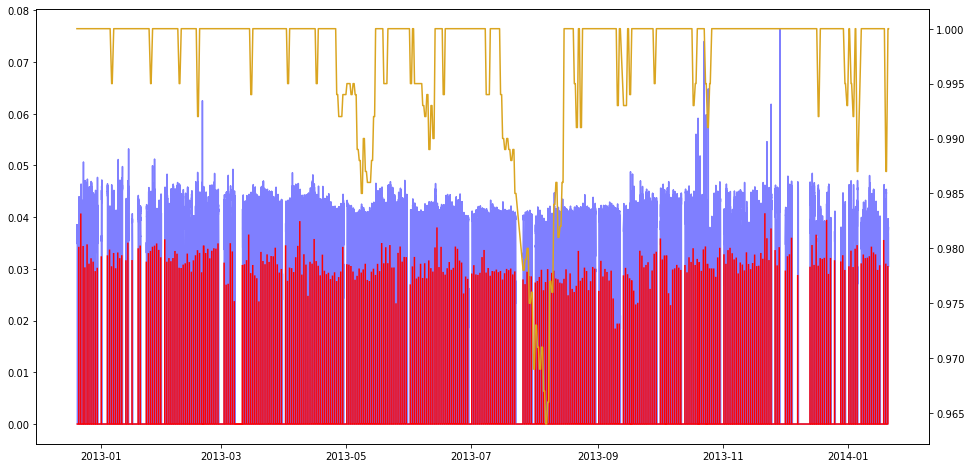

query:62, 1062 / 114122


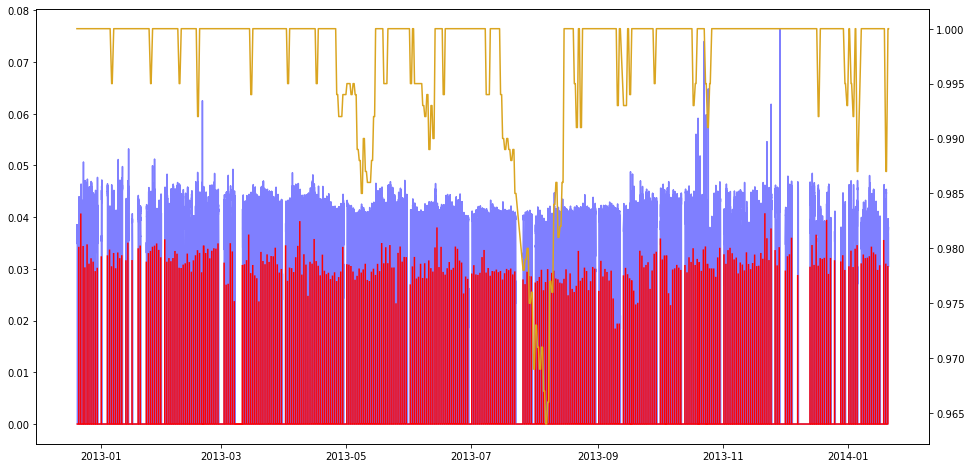

query:16, 1062 / 114122


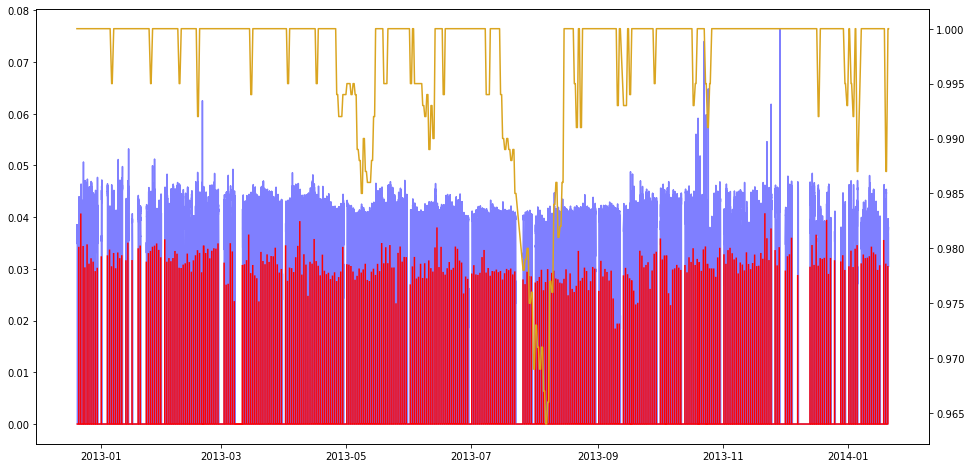

query:75, 1062 / 114122


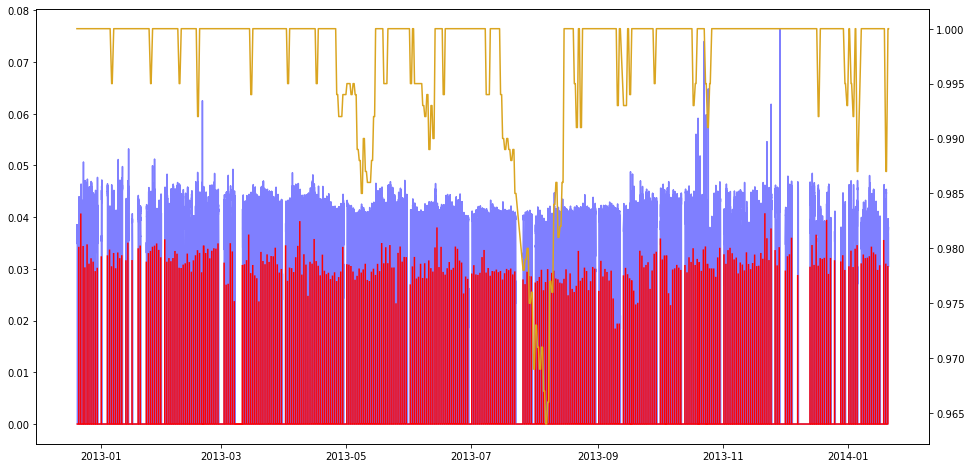

query:87, 1062 / 114122


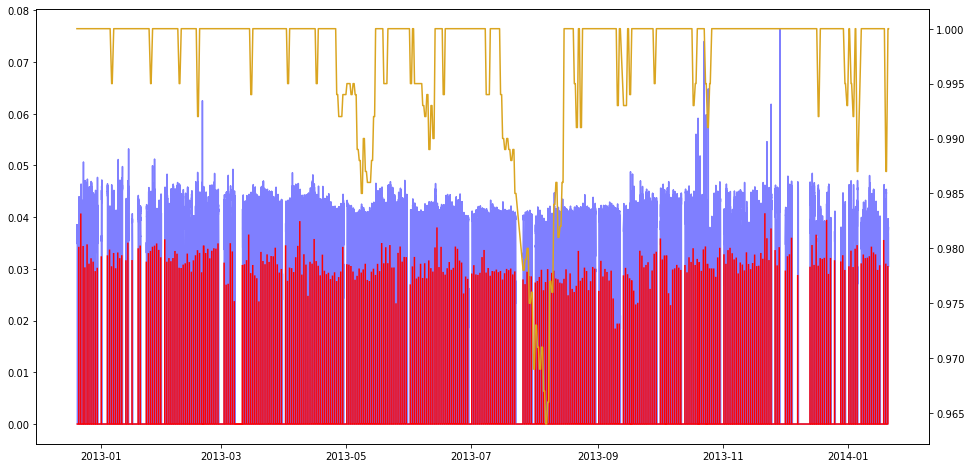

query:35, 1062 / 114122


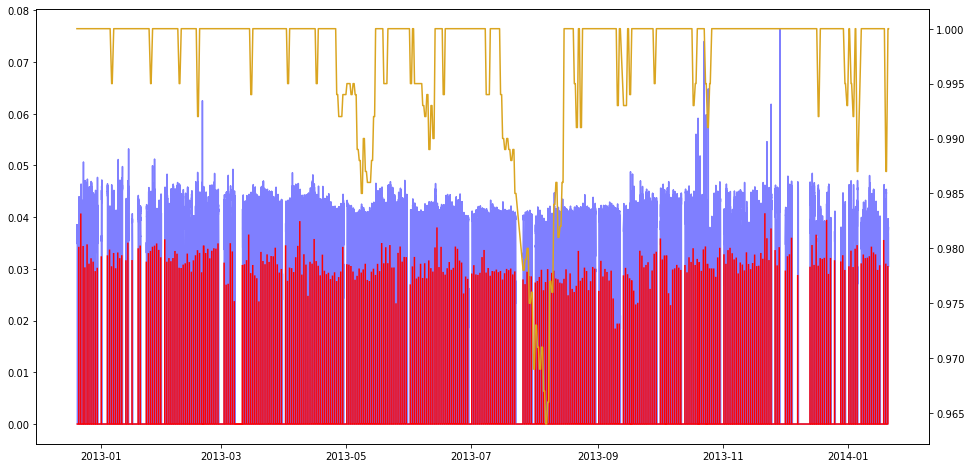

query:6, 1059 / 114122


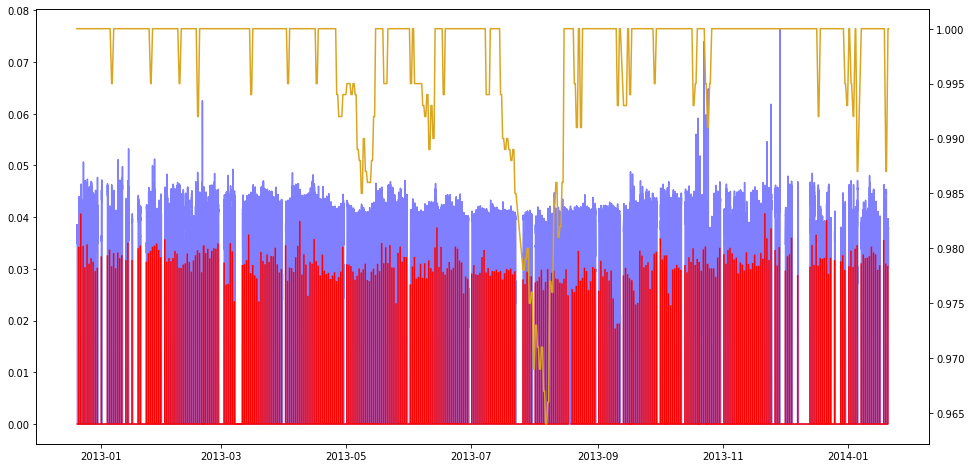

query:91, 1044 / 114122


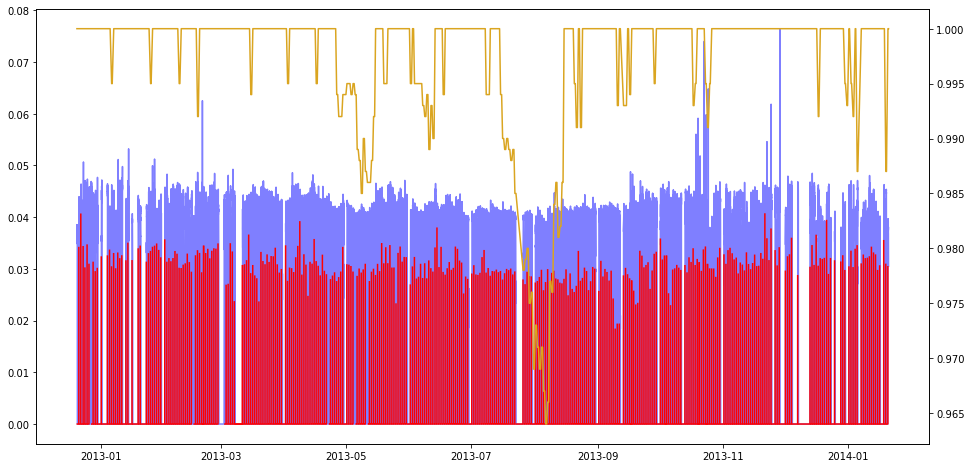

query:64, 1038 / 114122


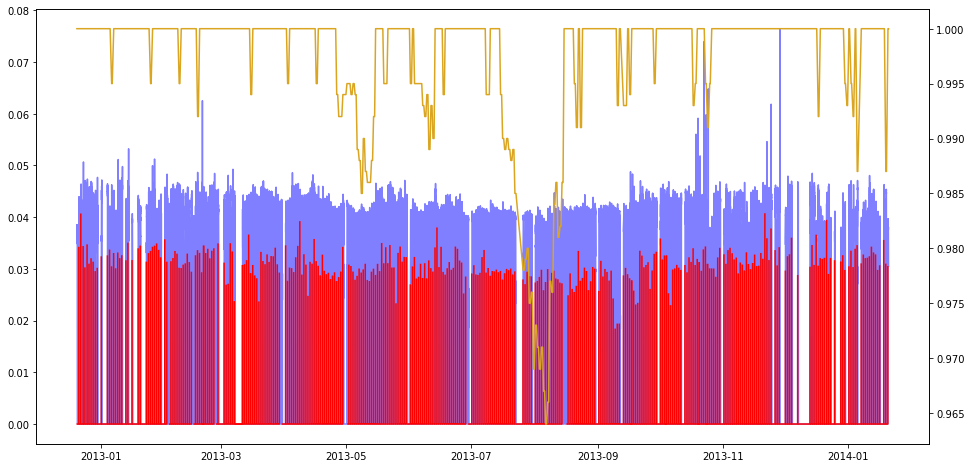

query:68, 156 / 114122


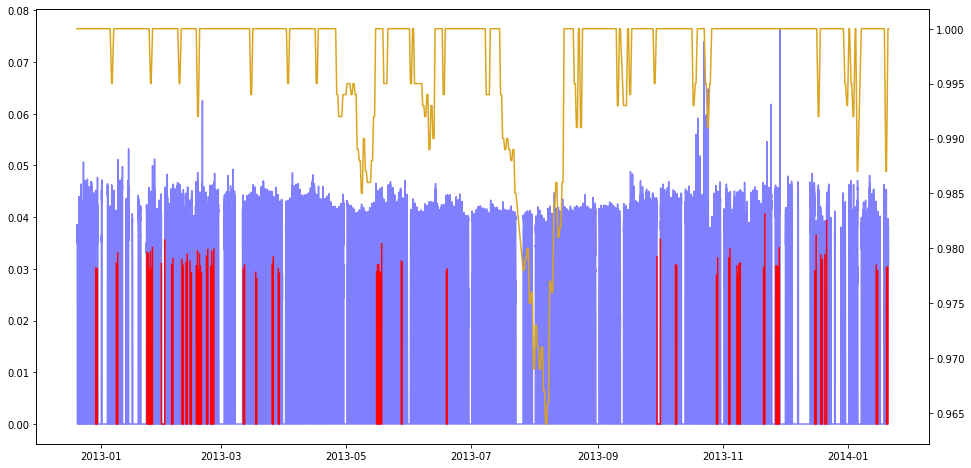

query:23, 156 / 114122


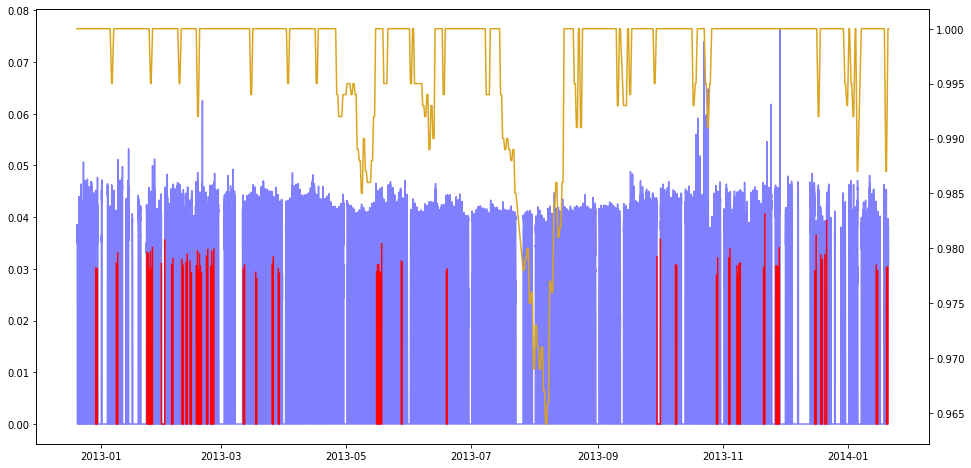

query:41, 156 / 114122


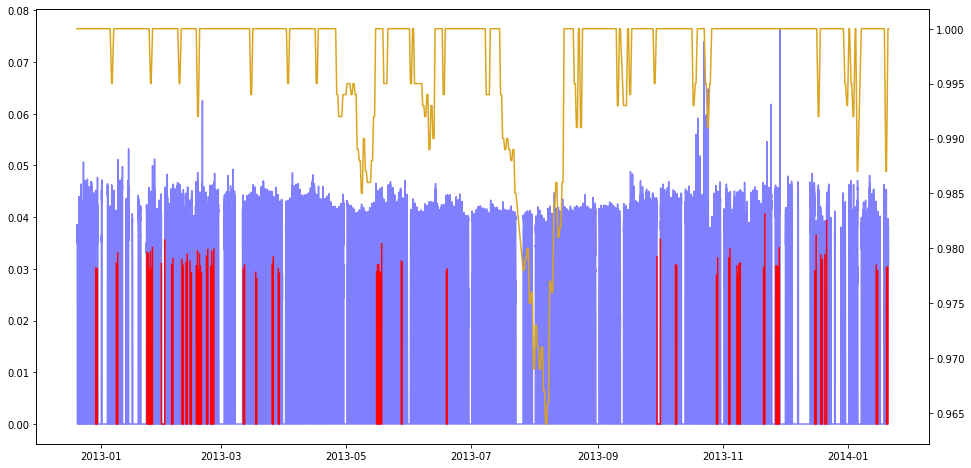

query:70, 156 / 114122


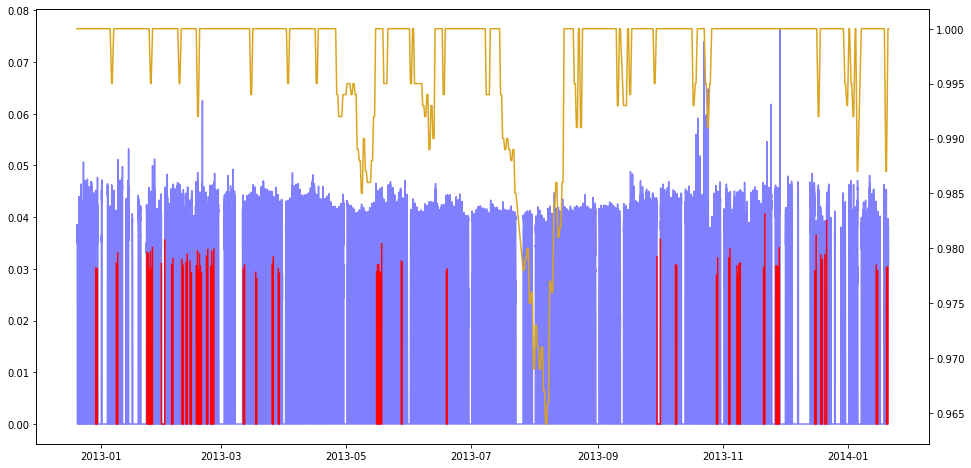

query:63, 156 / 114122


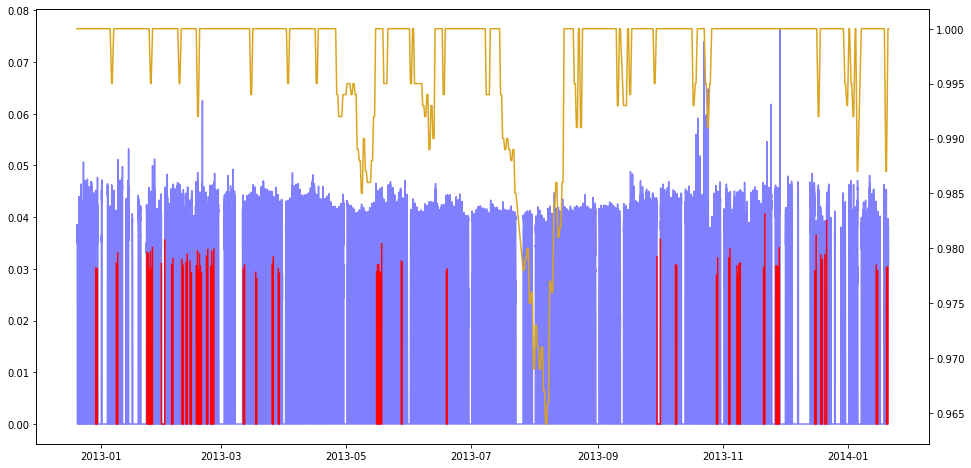

query:74, 156 / 114122


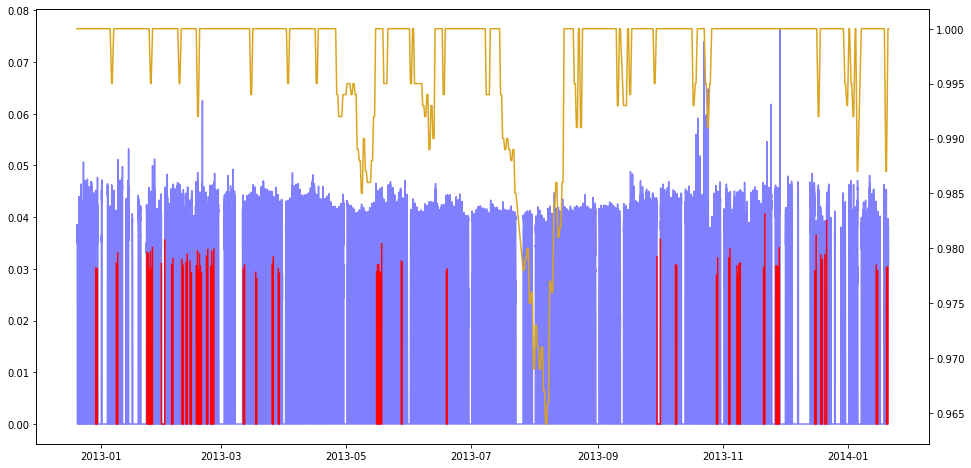

query:53, 156 / 114122


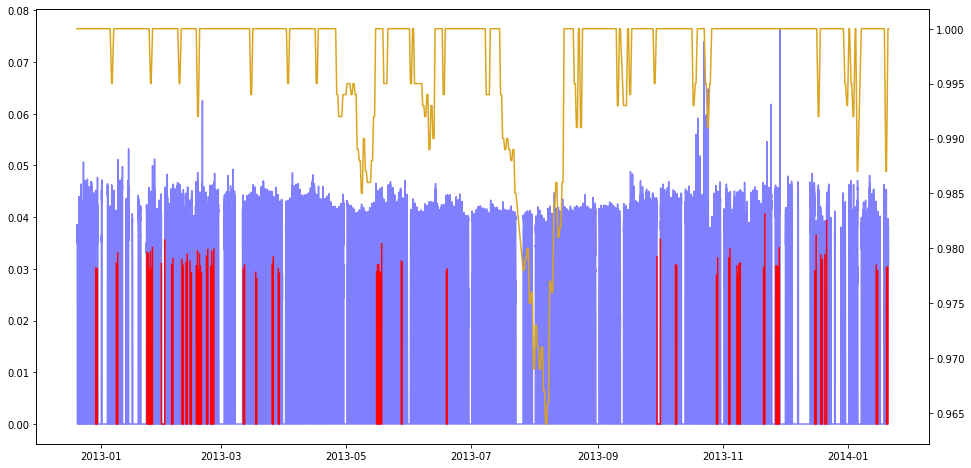

query:54, 156 / 114122


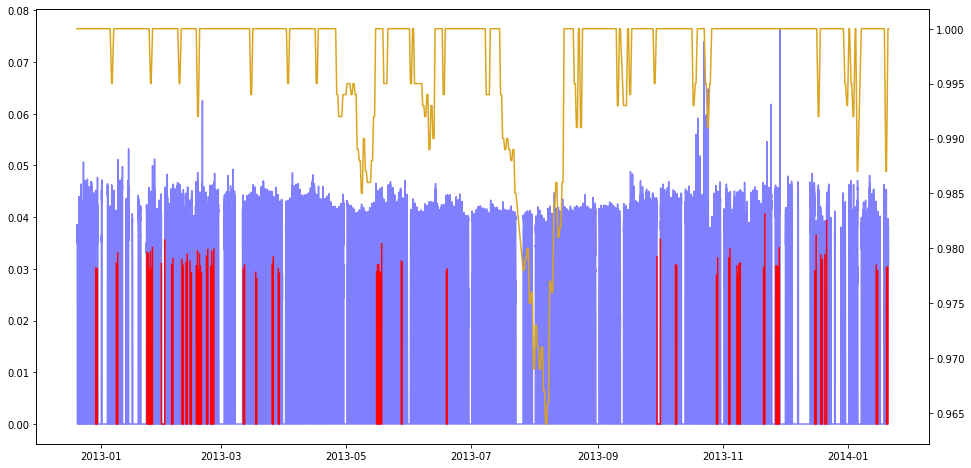

query:43, 156 / 114122


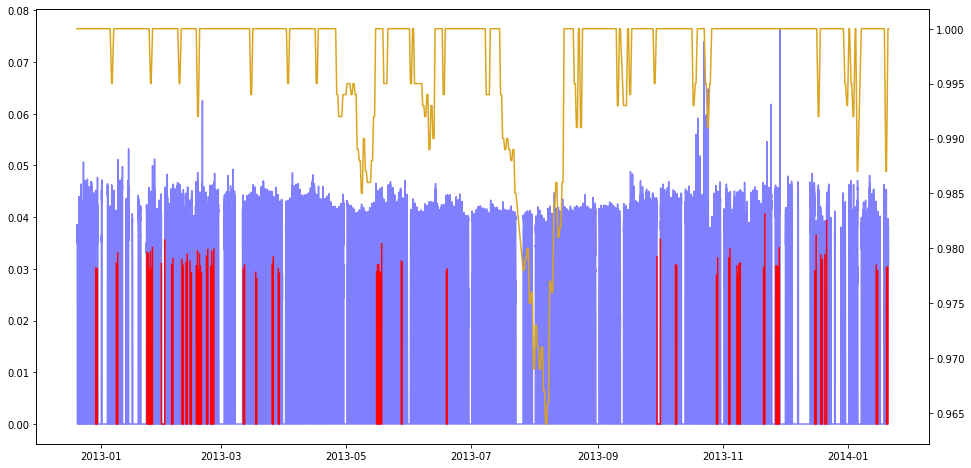

query:79, 156 / 114122


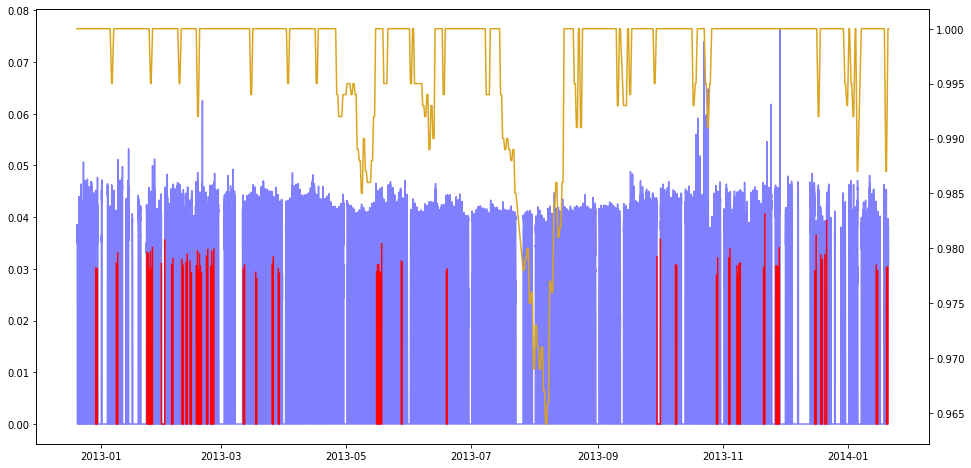

query:30, 156 / 114122


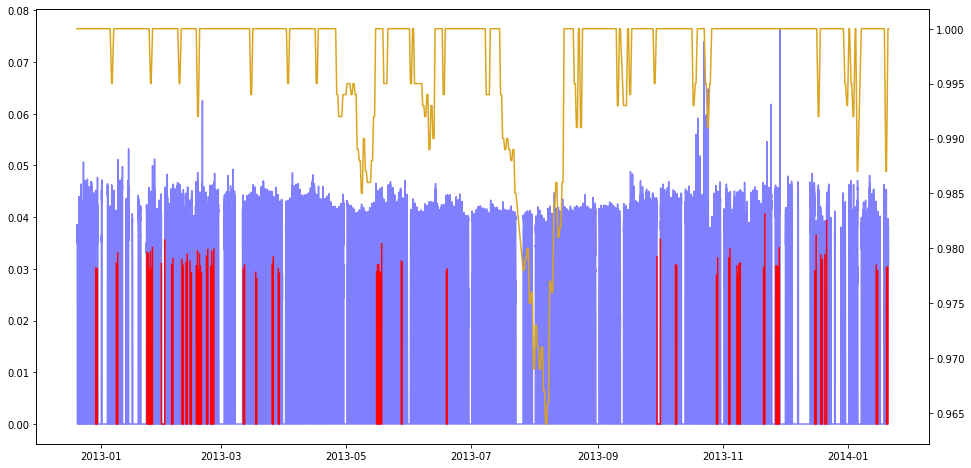

In [15]:
colors = ['red', 'green', 'black', 'yellow']
#for i in np.argsort(-np.array(n_answers))[:8]:
for i, signal in enumerate(series):
    n_answers = [len(x) for x in answers[i]]
    #use clustering criterion to choose answers
    for j in np.argsort(-np.array(n_answers))[:20]: 
        query = query_set[j]
        if len(answers[i][j])>0:
            #print(len(answers[i][j]))
            fig, ax = plt.subplots(figsize=(16, 8))
            ax.plot(original_signal, color = 'blue', alpha =0.5)
            ax2 = ax.twinx()

            ax2.plot(groundtruth.soiling_derate, color = 'goldenrod')
            #s = 0
            cover = pd.DatetimeIndex([])
            for k in answers[i][j]:                
                ax.plot(original_signal.loc[signal.iloc[k[0]:k[1]+2].index],color = colors[i], alpha = 1)
                cover = cover.union(original_signal.loc[signal.iloc[k[0]:k[1]+2].index].index)
            print(f'query:{j}, {len(cover)} / {len(original_signal)}')    
                #s = s + len(original_signal.loc[signal.iloc[k[0]:k[1]+2].index])
            #print(f'Motifs cover {s} timestamps in original')    
                #axes[k].legend()
            #ax.plot(dfs[0].soiling_derate["2013-03-10":"2013-03-30"], alpha=0.9,color = 'green')

            plt.show()   
   